# Downloads

In [1]:
!gdown 'https://docs.google.com/uc?export=download&id=1QDPNVVFwpXD6XhFJMTmxjQZ64Fntmvp_' #Fetch the dataset
!unzip imdb-reviews.csv.zip

Downloading...
From: https://docs.google.com/uc?export=download&id=1QDPNVVFwpXD6XhFJMTmxjQZ64Fntmvp_
To: /content/imdb-reviews.csv.zip
100% 24.6M/24.6M [00:00<00:00, 56.1MB/s]
Archive:  imdb-reviews.csv.zip
  inflating: imdb-reviews.csv        


# Imports

In [2]:
from sklearn                         import metrics
from nltk.tokenize                   import RegexpTokenizer
from sklearn.linear_model            import LogisticRegression
from sklearn.model_selection         import GridSearchCV
from sklearn.model_selection         import learning_curve
from sklearn.model_selection         import train_test_split
from sklearn.model_selection         import RepeatedStratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import os
import copy              as cp
import numpy             as np
import pandas            as pd
import seaborn           as sns
import multiprocessing
import matplotlib.pyplot as plt

# Data Preprocessing

## Convert the ratings to Boolean

In [3]:
df        = pd.read_csv('imdb-reviews.csv',sep='\t')
df.rating = df.rating.replace([0,1,2,3,4],0) #0 for the negative reviews
df.rating = df.rating.replace([7,8,9,10],1)  #1 for the positive reviews

df.head(5)

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,1.0,I thought this was a quiet good movie. It was ...
1,http://www.imdb.com/title/tt0043117/usercomments,1.0,Wagon Master is a very unique film amongst Joh...
2,http://www.imdb.com/title/tt0043117/usercomments,1.0,This film has to be as near to perfect a film ...
3,http://www.imdb.com/title/tt0835204/usercomments,0.0,I gave this 4 stars because it has a lot of in...
4,http://www.imdb.com/title/tt0499603/usercomments,1.0,This movie is really genuine and random. It's ...


## Check if the dataset is balanced

In [4]:
num = (df[df.rating == 1].rating.count()/df.rating.count()) * 100

print('The positive reviews are ', f'{num:.2f}', '\b% of the dataset.')

The positive reviews are  50.01 % of the dataset.


## Tokenization and Vectorization of the reviews

In [14]:
reg_token   = RegexpTokenizer(r'[a-zA-Z0-9]+') #Used to remove unwanted characters from the reviews (Keep only numbers and letters).
vectorizers = []                               #Used to save all the data vectorizing configurations.

for i in range(0,2):
    ngram   = i + 1

    vectorizers.append(  CountVectorizer(stop_words='english',
                                         ngram_range=(ngram,2),tokenizer=reg_token.tokenize,
                                         token_pattern=None,max_features=10000,binary=True))
    vectorizers.append(  TfidfVectorizer(stop_words='english',
                                         ngram_range=(ngram,2),tokenizer=reg_token.tokenize,
                                         token_pattern=None,max_features=10000,binary=True))

for vect in vectorizers:
    print(vect)

CountVectorizer(binary=True, max_features=10000, ngram_range=(1, 2),
                stop_words='english', token_pattern=None,
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)
TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2),
                stop_words='english', token_pattern=None,
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)
CountVectorizer(binary=True, max_features=10000, ngram_range=(2, 2),
                stop_words='english', token_pattern=None,
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)
TfidfVectorizer(binary=True, max_features=10000, ngram_range=(2, 2),
 

## Transform the data according to each vectorization method

In [6]:
fitted_reviews = []

for vect in vectorizers:
    fitted_reviews.append(vect.fit_transform(df.review))

## Create the train and test sets

In [7]:
train_test_split_list = [] #Save the train-test splits for each data preprocessing configuration

for fit_rev in fitted_reviews:
    x_train, x_test, y_train, y_test = train_test_split(fit_rev,df.rating, test_size=0.2, random_state=12345)
                           #80% train and 20% test sizes
    train_test_split_list.append((x_train, x_test, y_train, y_test))

# Defining the model

In [8]:
solvers         = ['liblinear']
penalty         = ['l1', 'l2']
c_values        = [1.0, 0.5]
tol_values      = [0.5, 0.1]

parameters      = dict(solver=solvers,penalty=penalty,C=c_values,tol=tol_values)
grid_cv         = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=12345)
model           = LogisticRegression()

grid_parameters = dict(estimator=model, param_grid=parameters,
                       n_jobs=multiprocessing.cpu_count(), cv=grid_cv, scoring='f1',
                       error_score='raise')

# Fitting the model

In [9]:
best_grid = None                                             #Save the best hyperparameter combination.
                                                             #best_grid = (train_test_split,grid_configuration,vectorizer_configuration)
for i,tts in enumerate(train_test_split_list):
    grid_search = GridSearchCV(**grid_parameters)
    grid_result = grid_search.fit(tts[0], tts[2])            #x_train, y_train

    if best_grid == None:
        best_grid = (tts,cp.deepcopy(grid_result),vectorizers[i])
    elif grid_result.best_score_ > best_grid[1].best_score_: #Save the one with the best mean (f1) score.
        best_grid = (tts,cp.deepcopy(grid_result),vectorizers[i])

print('Best:', f'{best_grid[1].best_score_:.5f}', '(f1 mean) using', best_grid[1].best_params_, '\b.')
print('Used the vectorizer with configuration:', best_grid[2])

Best: 0.90257 (f1 mean) using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.5} .
Used the vectorizer with configuration: TfidfVectorizer(binary=True, max_features=10000, ngram_range=(1, 2),
                stop_words='english', token_pattern=None,
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='[a-zA-Z0-9]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)


# Evaluating the model

## Learning Curve

In [10]:
tts    = best_grid[0] #train-test split selected.
gridCV = best_grid[1] #Best grid result.

train_size,train_score,test_score = learning_curve(LogisticRegression(**gridCV.best_params_),
                                                   tts[0],tts[2],scoring='f1',n_jobs=multiprocessing.cpu_count(),
                                                   random_state=12345,cv=grid_cv)

The mean train scores are: [0.95517073 0.94333911 0.93554939 0.93493448 0.93386705] .
The mean test  scores are: [0.8752746  0.89196746 0.89750248 0.9001069  0.90258468] .


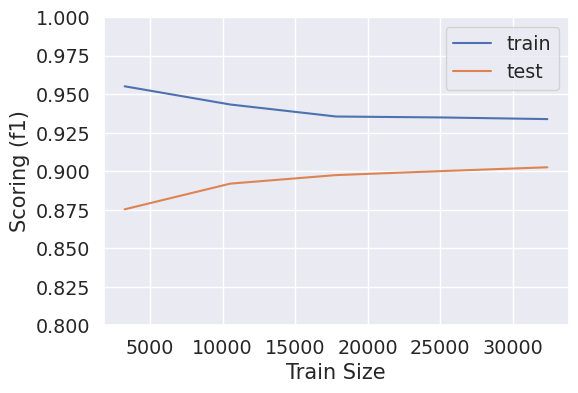

In [16]:
fig = plt.figure(figsize=(6,4))

mean_train = np.mean(train_score,axis=1)
mean_test  = np.mean(test_score, axis=1)

line1, = plt.plot(train_size,mean_train, label='train')
line2, = plt.plot(train_size,mean_test , label='test' )

_ = plt.ylim(0.8,1)
_ = plt.grid(True)
_ = plt.xlabel('Train Size')
_ = plt.ylabel('Scoring (f1)')
_ = plt.rcParams.update({'font.size': 8})
_ = plt.legend(handles=[line1, line2],loc='best')

print('The mean train scores are:', mean_train, '\b.')
print('The mean test  scores are:', mean_test , '\b.')

## Confusion Matrix

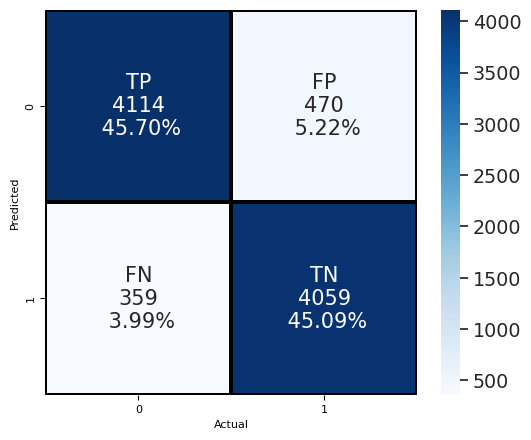

In [12]:
tts    = best_grid[0] #train-test split selected.
gridCV = best_grid[1] #Best grid result.

predicted = gridCV.predict(tts[1])

cm_values = metrics.confusion_matrix(tts[3],predicted)
np.fill_diagonal(cm_values,cp.deepcopy(np.flip(cm_values.diagonal())))
                      #The output is [[tn, fp], [fn, tp]],
                      #but we need [[tp, fp], [fn, tn]],
                      #so we reverse the diagonal.

names   = ['TP','FP','FN','TN']
counts  = ['{0:0.0f}'.format(value) for value in cm_values.flatten()]
percent = [' {0:.2%}'.format(value) for value in cm_values.flatten()/np.sum(cm_values)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
        zip(names,counts,percent)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(6,5))
sns.set(font_scale=1.25)

r = sns.heatmap(cm_values,fmt='', linecolor='black',annot=labels,cmap='Blues',linewidths=1.5)

_ = r.set(xlabel='Actual',ylabel='Predicted')

## F1 score

In [13]:
num = metrics.f1_score(best_grid[0][3],predicted)

print('The F1 score for the best configuration is:',f'{num:.5f}','\b.')

The F1 score for the best configuration is: 0.90847 .
